In [1]:
#import the necessary libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

The 'Wholesale customers' dataset contains the annual spending of the clients of a wholesale distributor on different product categories, along with their regions and channels. 
<br>
<br>
Download link - https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv 

In [3]:
#import the data

df = pd.read_csv("Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Data Cleaning (1)

In [4]:
df.shape

(440, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
df.rename({"Detergents_Paper": "Detergents Paper", "Delicassen": "Delicatessen "}, axis =1, inplace =True)

**Missing Values**

In [7]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents Paper    0
Delicatessen        0
dtype: int64

There are no missing values in the dataset

**Outliers**

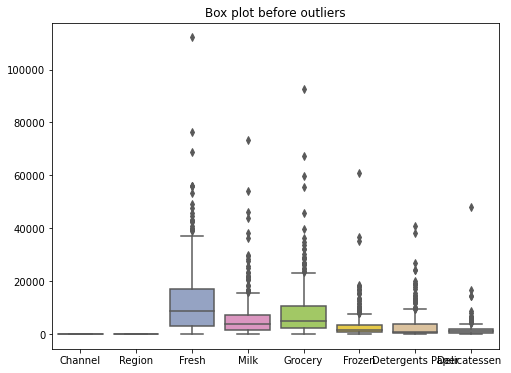

In [8]:
plt.figure(figsize = (8,6))
sns.boxplot(data=df, palette="Set2")
plt.title("Box plot before outliers")
plt.show()

In [9]:
#removing the outliers

outliers_list = []
for feature in df.keys():
    
    # Calculate Q1 (25th percentile) for each feature
    Q1 = np.percentile(df[feature], 25)
    
    # Calculate Q3 (75th percentile) for each feature
    Q3 = np.percentile(df[feature], 75)
    
    # Using 1.5*Interquartile range to define the upper and lower boundaries
    step = (Q3 - Q1) * 1.5
    
    outliers = list(df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))].index.values)
    outliers_list.extend(outliers)

duplicate_outliers_list = list(set([x for x in outliers_list if outliers_list.count(x) >= 2]))
duplicate_outliers_list.sort()


outliers  = duplicate_outliers_list

# Remove the outliers
df = df.drop(df.index[outliers]).reset_index(drop = True)

print("Number of outliers in the data that was removed:", len(outliers))

Number of outliers in the data that was removed: 41


**Relationship between variables**

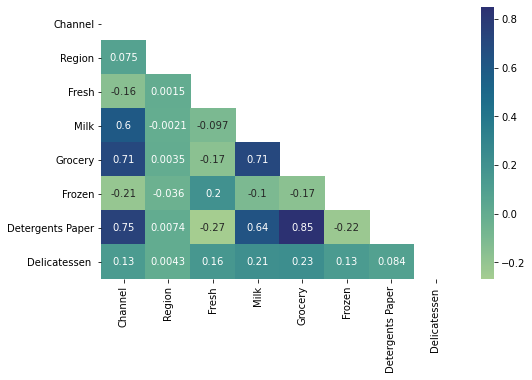

In [10]:
plt.figure(figsize = (8,5))

mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(), annot = True,
           mask = mask, cmap = "crest")

plt.show()

- The amounts spent by clients on grocery and detergents paper were strongly and positively correlated. 
- A moderately strong correlation between grocery and milk is also visible. 

### Exploratory Data Analysis

#### Does the spending on different product categories differ based on the region and channel?

##### Region

<Figure size 576x432 with 0 Axes>

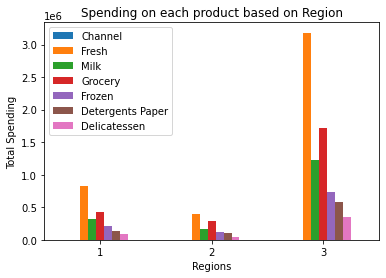

In [20]:
plt.figure(figsize=(8,6))
df.groupby("Region").sum().plot.bar(rot=0)

plt.title("Spending on each product based on Region")
plt.xlabel("Regions")
plt.ylabel("Total Spending")

plt.show()

> - Region 3 (other) has the highest spending out of the three regions, whilst region 2 (Oporto) has the lowest. 
> - All three regions's spending patterns on different product categories seem to be the same. 
> - The highest spending is on Fresh products, followed by Grocery, Milk and Frozen and the lowest being on Delicatessen. 

##### Channel

<Figure size 576x432 with 0 Axes>

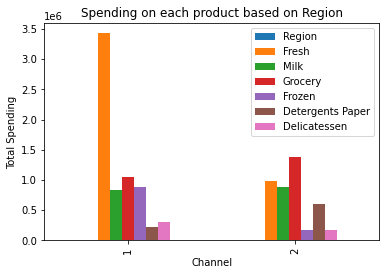

In [21]:
plt.figure(figsize=(8,6))
df.groupby("Channel").sum().plot.bar()

plt.title("Spending on each product based on Region")
plt.xlabel("Channel")
plt.ylabel("Total Spending")

plt.show()

> - Channel 1 (Hotel, Restarant, Cafe) spends more than Channel 2 (Retail)
> - Channel 1 spends more on Fresh products whilst channel 2 spends more on Grocery. 

### Data Preprocessing

#### Scaling the data

In [22]:
std = StandardScaler()

df_scaled = std.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns = list(df.columns))

### Principal Component Analysis (PCA)

In [23]:
pca = PCA(n_components = None)
df_pca = pca.fit_transform(df_scaled)
explained_var = pca.explained_variance_ratio_

print("Number of principal components:", len(explained_var))
print("Variance explained by each principal component: \n",explained_var)

Number of principal components: 8
Variance explained by each principal component: 
 [0.41063617 0.16766433 0.1261344  0.10010875 0.09231353 0.05052574
 0.0368016  0.01581548]


#### Scree Plot

The Scree plot helps to identify how many principal components are of interest - it shows the proportion of variance explained by each PC

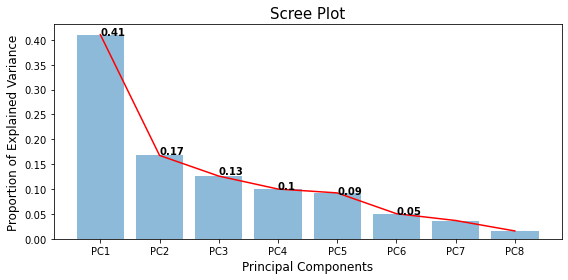

In [24]:
fig = plt.figure(figsize=(8,4))
pcs = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]

plt.bar(pcs, explained_var, alpha=0.5, align='center',label='Individual Explained Variance')
plt.plot(range(8),explained_var, c='red', label='Per Component Explained Variance')

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'left', fontsize = 10, fontweight = "bold")

        
addlabels(range(6), np.round(explained_var,2))

plt.ylabel('Proportion of Explained Variance',fontsize = 12)
plt.xlabel('Principal Components',fontsize = 12)
plt.title('Scree Plot',fontsize = 15)

plt.tight_layout()
#plt.savefig("Scree plot.png")
plt.show()

#### Cumulative Explained Variance Plot

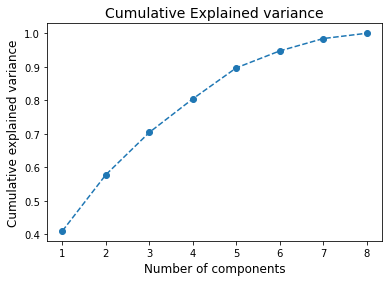

In [25]:
plt.plot(range(1, len(df.columns)+1), 
         explained_var.cumsum(),
         marker='o', linestyle='--'
        )

plt.title("Cumulative Explained variance", fontsize = 14)
plt.xlabel("Number of components", fontsize = 12)
plt.ylabel("Cumulative explained variance", fontsize = 12)

#plt.savefig("Cumulative explained variance.png")
plt.show()

#### Choosing only the first 3 PCs

In [26]:
#PCA with n = 3

pca3 = PCA(n_components = 3)
df_pca3 = pca3.fit_transform(df_scaled)

#### Loading Matrix

This shows the amount of contribution that each variable has in a particular Principal Component

In [27]:
loadings = pca3.components_.T * np.sqrt(pca3.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], 
                              index=df_scaled.columns)
loading_matrix

,PC1,PC2,PC3
Channel,0.858167,0.008240,-0.073911
Region,0.036595,-0.051377,-0.988044
Fresh,-0.277315,0.643015,-0.117859
Milk,0.810856,0.191184,0.040973
Grocery,0.922111,0.108140,0.035994
Frozen,-0.282898,0.598429,0.092229
Detergents Paper,0.918682,-0.073942,0.041462
Delicatessen,0.216484,0.718804,-0.053173


#### Loading Plot - For 2 PCs 

The loading plot shows how strongly each feature impacts a principal component

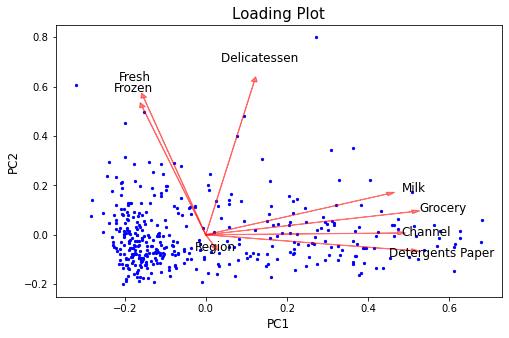

In [28]:
#PCA with only the first 2 components
pca2 = PCA(n_components = 5)
df_pca2 = pca2.fit_transform(df_scaled)


def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5, color = "b")
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5, head_width = 0.015, head_length = 0.02)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center',
                    fontsize = 12)
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'black', ha = 'center', va = 'center', 
                    fontsize = 12)
            

    plt.xlabel("PC{}".format(1), fontsize = 12)
    plt.ylabel("PC{}".format(2), fontsize = 12)
    plt.title("Loading Plot", fontsize = 15)
    #plt.savefig("Loading Plot")

    
    
plt.figure(figsize=(8, 5))
biplot(df_pca, np.transpose(pca2.components_), list(df.columns))

Interpretation of the loading plot:
<br>
- The loading for Region is almost 0, indicating that it has no impact on both the PCs
- Milk, Grocery, Channel and Detergents Paper have positive loadings on PC1, meaning they have more weightage on PC1
- Fresh, Frozen and Delicassen have positive loadings on PC2, meaning that they have more weightage on PC2

### K-Means Clustering

Clustering has been applied to the PCA-transformed data

#### Cluster inertia vs Number of clusters

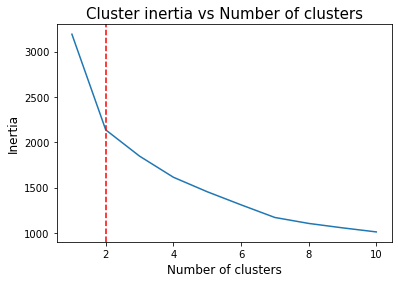

In [29]:
inertia = []

#running k-means clustering for k from 1-11
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state= 2)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)  

#plotting the corresponding inertia of each k
plt.plot(range(1,11),inertia)
plt.axvline(x = 2, color = "r", linestyle = "--")

plt.xlabel("Number of clusters", fontsize = 12)
plt.ylabel("Inertia", fontsize = 12)
plt.title("Cluster inertia vs Number of clusters", fontsize = 15)

#plt.savefig("Cluster inertia.png")
plt.show()

k=2 seems to be the ideal number of clusters according to the above plot

#### Visualization of the clusters

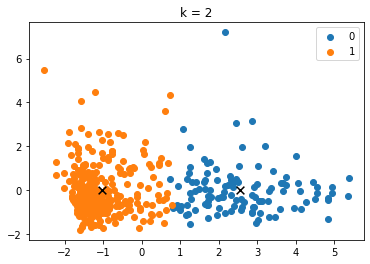

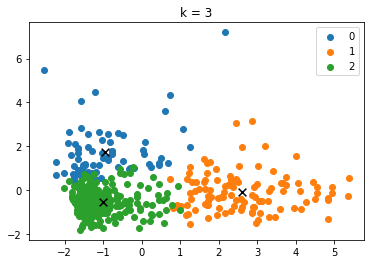

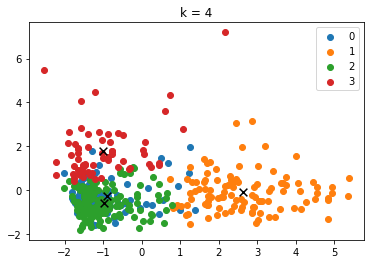

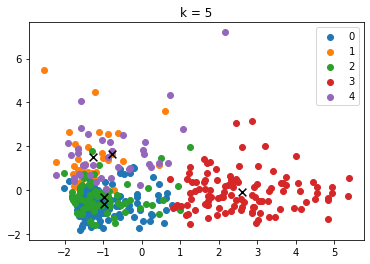

In [30]:
def clusters(df, n):
    kmeans = KMeans(n_clusters = n)
    label = kmeans.fit_predict(df)
    u_labels = np.unique(label)
    centroids = kmeans.cluster_centers_
    
    
    #plotting the results
    
    for i in u_labels:
        plt.scatter(df[label == i, 0], df[label == i, 1], label = i)
        
    plt.scatter(centroids[:,0], centroids[:,1], color = "black", marker = "x", s = 60)
    plt.legend()
    plt.title("k = " + str(n))
    
    plt.show()

    
for n in range(2,6):
    clusters(df_pca, n)

It can be seen that as the number of clusters exceeds 2, there seems to be an overlap between the clusters

With k=2,  
The derived clusters can be interpreted as follows: 

 - Cluster 1: More spending on Grocery, Milk and Detergents Paper – Small retailers
 - Cluster 2: More spending on Fresh, Frozen and Delicatessen – High-end supermarkets